## Ensure Spark is running

In [1]:
print(sc.version)


3.2.4


In [2]:
# Check the master URL of the SparkContext
print(sc.master)

local[*]


# Previous steps (Terminal commands)

## A. Run Hadoop using an extended hdfs script created by me using Muhammed's script as a base option 1

./hdfs_extended

(equivalent to "start-dfs.sh" and "start-yarn.sh")


## B. Create a new folder in Hadoop File Sytem called "CA1"

hadoop fs -mkdir /CA1


## C. Copy my dataset with TAB separators instead of commas to the folder I've just created

hadoop fs -put /media/sf_CA1/lyrics-dataTAB.csv /CA1


## D. Ensure it is there

hadoop fs -ls /CA1


## E. Run a script I created to replace all double quote characters to single quote characters and create a new file called "lyrics-dataTAB_fixed.csv"

Code for the script:

#!/bin/bash

#Define your HDFS file paths
input_path="/CA1/lyrics-dataTAB.csv"
output_path="/CA1/lyrics-dataTAB_fixed.csv"

#Check if the output file already exists and remove it to avoid errors

hdfs dfs -test -e $output_path && hdfs dfs -rm $output_path

#Use hdfs dfs -cat to output the file content, then sed to replace " with ' and then use hdfs dfs -put to store the result back into HDFS

hdfs dfs -cat $input_path | sed "s/\"/'/g" | hdfs dfs -put - $output_path


Terminal code to tun it:

./scriptToReplaceDoubleQuotesWithSingleQuotes

# DATA-PREPROCESSING with Spark over file in Hadoop File System

# 01. Load csv with tab separator from hadoop filesystem

In [3]:
# Read a CSV file into a DataFrame
df = spark.read.csv("hdfs:///CA1/lyrics-dataTAB_fixed.csv", sep='\t', header=True, multiLine = True, escape = "\n")

df.show(20)

# Count the number of rows
row_count = df.count()

# Show the row count
print(f"The total number of rows is: {row_count}")

+---------------+--------------------+--------------------+--------------------+--------+
|          ALink|               SName|               SLink|               Lyric|language|
+---------------+--------------------+--------------------+--------------------+--------+
|/ivete-sangalo/|               Arerê|/ivete-sangalo/ar...|'Tudo o que eu qu...|      pt|
|/ivete-sangalo/|Se Eu Não Te Amas...|/ivete-sangalo/se...|'Meu coração\nSem...|      pt|
|/ivete-sangalo/|         Céu da Boca|/ivete-sangalo/ch...|'É de babaixá!\nÉ...|      pt|
|/ivete-sangalo/|Quando A Chuva Pa...|/ivete-sangalo/qu...|'Quando a chuva p...|      pt|
|/ivete-sangalo/|        Sorte Grande|/ivete-sangalo/so...|'A minha sorte gr...|      pt|
|/ivete-sangalo/|    A Lua Q Eu T Dei|/ivete-sangalo/a-...|'Posso te falar d...|      pt|
|/ivete-sangalo/|Mulheres Não Têm ...|/ivete-sangalo/mu...|'Hey, girl\nLevan...|      pt|
|/ivete-sangalo/|Eva / Alô Paixão ...|/ivete-sangalo/ev...|'''EVA''\n(Gianca...|      pt|
|/ivete-sa

The total number of rows is: 389622


# 02. Drop rows that contain some null value

In [4]:
# Drop rows that have any null values
df = df.dropna()

# Count the number of rows
row_count = df.count()

# Show the row count
print(f"The total number of rows is: {row_count}")

The total number of rows is: 364924


# 03. Drop duplicates

In [5]:
# To drop identical rows across all columns
df_no_identical = df.distinct()

# Count the number of rows
row_count = df.count()

# Show the row count
print(f"The total number of rows is: {row_count}")

The total number of rows is: 364924


# 04. Replace newline codes (\n) with spaces in Lyric column

In [6]:
from pyspark.sql.functions import regexp_replace

# Replace newline characters with a space in the "lyric" column
df = df.withColumn("lyric", regexp_replace("lyric", "\n", " "))

# Count the number of rows
row_count = df.count()

# Show the row count
print(f"The total number of rows is: {row_count}")

The total number of rows is: 364924


# 05. Drop rows with language codes with more than 2 characters

In [7]:
from pyspark.sql.functions import length


# Filter rows to keep only those where "language" column has <= 2 characters
df = df.filter(length(df.language) <= 2)

# Show the filtered DataFrame (optional)
df.show()

# Count the number of rows
row_count = df.count()

# Show the row count
print(f"The number of rows is: {row_count}")

+---------------+--------------------+--------------------+--------------------+--------+
|          ALink|               SName|               SLink|               lyric|language|
+---------------+--------------------+--------------------+--------------------+--------+
|/ivete-sangalo/|               Arerê|/ivete-sangalo/ar...|'Tudo o que eu qu...|      pt|
|/ivete-sangalo/|Se Eu Não Te Amas...|/ivete-sangalo/se...|'Meu coração Sem ...|      pt|
|/ivete-sangalo/|         Céu da Boca|/ivete-sangalo/ch...|'É de babaixá! É ...|      pt|
|/ivete-sangalo/|Quando A Chuva Pa...|/ivete-sangalo/qu...|'Quando a chuva p...|      pt|
|/ivete-sangalo/|        Sorte Grande|/ivete-sangalo/so...|'A minha sorte gr...|      pt|
|/ivete-sangalo/|    A Lua Q Eu T Dei|/ivete-sangalo/a-...|'Posso te falar d...|      pt|
|/ivete-sangalo/|Mulheres Não Têm ...|/ivete-sangalo/mu...|'Hey, girl Levant...|      pt|
|/ivete-sangalo/|Eva / Alô Paixão ...|/ivete-sangalo/ev...|'''EVA'' (Giancar...|      pt|
|/ivete-sa

The number of rows is: 364922


# 06. Add a new column to the DataFrame with unique row identifiers (IDs)

In [8]:
from pyspark.sql.functions import monotonically_increasing_id

# Add a new column 'id' with unique row IDs
df = df.withColumn("id", monotonically_increasing_id())

# Show the result
df.show()

+---------------+--------------------+--------------------+--------------------+--------+---+
|          ALink|               SName|               SLink|               lyric|language| id|
+---------------+--------------------+--------------------+--------------------+--------+---+
|/ivete-sangalo/|               Arerê|/ivete-sangalo/ar...|'Tudo o que eu qu...|      pt|  0|
|/ivete-sangalo/|Se Eu Não Te Amas...|/ivete-sangalo/se...|'Meu coração Sem ...|      pt|  1|
|/ivete-sangalo/|         Céu da Boca|/ivete-sangalo/ch...|'É de babaixá! É ...|      pt|  2|
|/ivete-sangalo/|Quando A Chuva Pa...|/ivete-sangalo/qu...|'Quando a chuva p...|      pt|  3|
|/ivete-sangalo/|        Sorte Grande|/ivete-sangalo/so...|'A minha sorte gr...|      pt|  4|
|/ivete-sangalo/|    A Lua Q Eu T Dei|/ivete-sangalo/a-...|'Posso te falar d...|      pt|  5|
|/ivete-sangalo/|Mulheres Não Têm ...|/ivete-sangalo/mu...|'Hey, girl Levant...|      pt|  6|
|/ivete-sangalo/|Eva / Alô Paixão ...|/ivete-sangalo/ev...|'

# 07. Save "Lyrics-dataForHbase.csv" with tab separator to hadoop filesystem

In [11]:
# Write the DataFrame to a new CSV file
df.write.option("header", "true").option("sep", "\t").csv("hdfs:///CA1/lyrics-dataForHbase.csv")


# 08. Import preprocessed file from Hadoop into HBase (Terminal commands)

## 8.1 Ensure "lyrics-dataForHbase.csv" is in hadoop filesystem

hadoop fs -ls /CA1

## 8.2 Run hbase using my extended script option 4

./hdfs_extended

(equivalent to /usr/local/hbase/bin/start-hbase.sh)

## 8.3 Run hbase shell using my extended script option 6

./hdfs_extended

(equivalent to /usr/local/hbase/bin/hbase shell)

## 8.4 Create "Lyrics" table in hbase shell

create 'Lyrics', 'cf'

## 8.5 Import "lyrics-dataForHbase.csv" from hadoop filesystem to HBase

bin/hbase org.apache.hadoop.hbase.mapreduce.ImportTsv \
-Dimporttsv.columns=cf:ALink,cf:SName,cf:SLink,cf:Lyric,cf:language,HBASE_ROW_KEY \
-Dmapreduce.input.fileinputformat.input.charset=UTF-8 \
Lyrics hdfs:///CA1/lyrics-dataForHbase.csv

## 8.6 Run Thrift server (needed for Happy Base)

/usr/local/hbase/bin/hbase thrift start

# 09. Access HBase from notebook using HappyBase python library

In [ ]:
!#pip install happybase

In [2]:
import happybase
import pandas as pd

# Connect to HBase
connection = happybase.Connection('localhost')
table = connection.table('Lyrics')

# Extract all rows from HBase into a list
rows = [data for _, data in table.scan()]

# Construct DataFrame
happybasedf = pd.DataFrame(rows)

# Convert bytes columns to string
for column in happybasedf.columns:
    happybasedf[column] = happybasedf[column].str.decode('utf-8')

happybasedf.head(50)


,b'cf:ALink',b'cf:Lyric',b'cf:SLink',b'cf:SName',b'cf:language'
0,/ivete-sangalo/,"'Tudo o que eu quero nessa vida, Toda vida, é ...",/ivete-sangalo/arere.html,Arerê,pt
1,/ivete-sangalo/,'Meu coração Sem direção Voando só por voar Se...,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Se Eu Não Te Amasse Tanto Assim,pt
2,/ivete-sangalo/,"'Odô, axé odô, axé odô, axé odô Odô, axé odô, ...",/ivete-sangalo/muito-obrigado-axe.html,Muito Obrigado Axé,pt
3,/ivete-sangalo/,"'Deus meu Pai meu Amor meu Tudo, razão de tudo...",/ivete-sangalo/deus-da-minha-vida.html,Deus da Minha Vida,pt
4,/claudia-leitte/,'Já sei namorar Já sei beijar de língua Agora ...,/claudia-leitte/ja-sei-namorar-the-voice.html,Já Sei Namorar (The Voice),pt
5,/destinys-child/,'I'll be your bridge you can use to Whenever y...,/destinys-child/bridges.html,Bridges,en
6,/elia-oliveira/,'A minha história foi escrita pelas mãos de De...,/elia-oliveira/e-ele.html,É Ele,pt
7,/elia-oliveira/,'Estou cansado e sem forças Porém tenho que av...,/elia-oliveira/paz-no-vale.html,Paz no Vale,pt
8,/elia-oliveira/,'Diante do trono do meu grande Deus Eu me pros...,/elia-oliveira/cantico-de-adoracao.html,Cântico de Adoração,pt
9,/elia-oliveira/,'Em direção á abel de bete-maaca Seguem as tro...,/elia-oliveira/sabedoria.html,Sabedoria,pt


# 10. Access HBase from notebook using HappyBase python library

In [17]:
#!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


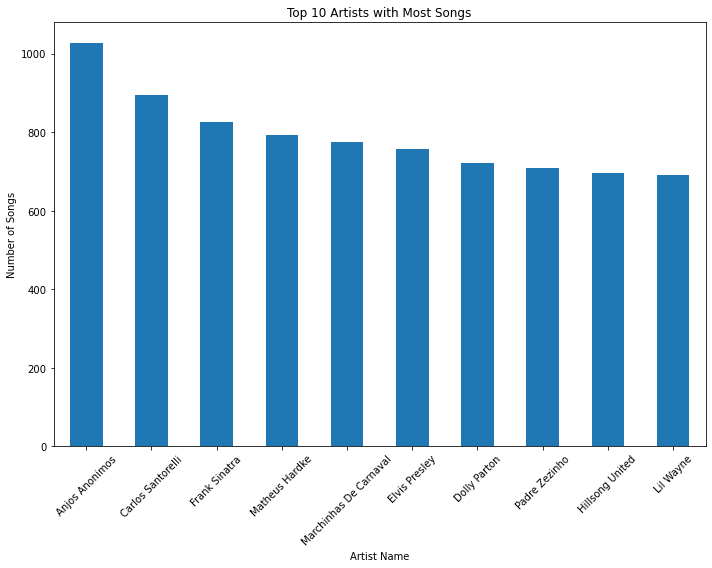

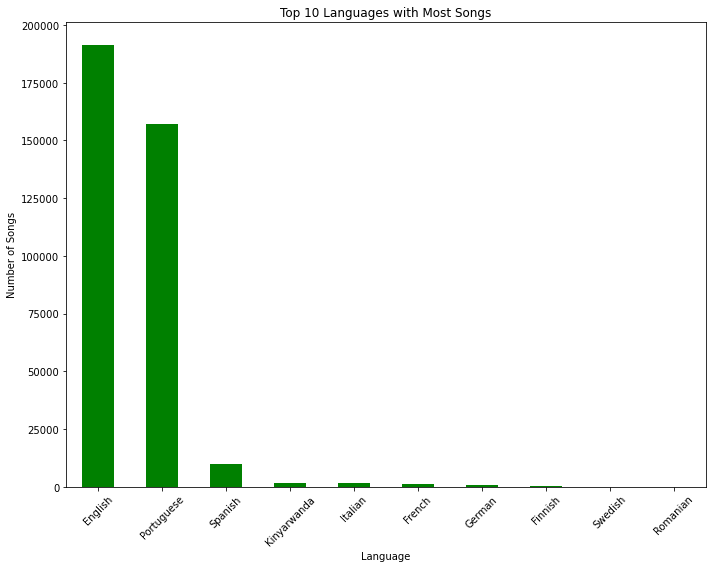

In [3]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame after reading from HBase

# Format the artist links into proper names
happybasedf["artist_name"] = happybasedf[b"cf:ALink"].str.replace(r'\/|-', ' ').str.title()

happybasedf[b'cf:ALink'] = happybasedf[b'cf:ALink'].astype(str)
happybasedf['artist_name'] = happybasedf[b'cf:ALink'].str.replace('/', '').str.replace('-', ' ').str.title()


# Count the number of songs by artist and get the top 10
artist_counts = happybasedf["artist_name"].value_counts().head(10)

# Define the language mapping data
language_mapping_data = [
    ("en", "English"),
    ("vi", "Vietnamese"),
    ("ro", "Romanian"),
    ("lv", "Latvian"),
    ("pl", "Polish"),
    ("st", "Sotho"),
    ("pt", "Portuguese"),
    ("gl", "Galician"),
    ("tl", "Tagalog"),
    ("sw", "Swahili"),
    ("ko", "Korean"),
    ("ms", "Malay"),
    ("cs", "Czech"),
    ("mg", "Malagasy"),
    ("sr", "Serbian"),
    ("tr", "Turkish"),
    ("de", "German"),
    ("is", "Icelandic"),
    ("es", "Spanish"),
    ("hr", "Croatian"),
    ("eu", "Basque"),
    ("lg", "Ganda"),
    ("it", "Italian"),
    ("af", "Afrikaans"),
    ("ku", "Kurdish"),
    ("su", "Sundanese"),
    ("ar", "Arabic"),
    ("sv", "Swedish"),
    ("nl", "Dutch"),
    ("rw", "Kinyarwanda"),
    ("hu", "Hungarian"),
    ("ca", "Catalan"),
    ("ru", "Russian"),
    ("iw", "Hebrew"),
    ("ga", "Irish"),
    ("ht", "Haitian Creole"),
    ("no", "Norwegian"),
    ("fa", "Persian"),
    ("cy", "Welsh"),
    ("et", "Estonian"),
    ("zh", "Chinese"),
    ("fr", "French"),
    ("ja", "Japanese"),
    ("gd", "Scottish Gaelic"),
    ("id", "Indonesian"),
    ("ny", "Chichewa"),
    ("da", "Danish"),
    ("sq", "Albanian"),
    ("fi", "Finnish"),
    ("jw", "Javanese"),
    # Add more mappings here
]

# Define the language mapping dictionary
language_mapping_dict = dict(language_mapping_data)

# Map the language codes to language names
happybasedf["language_name"] = happybasedf[b'cf:language'].map(language_mapping_dict)

# Count the number of songs by language and get the top 10
language_counts = happybasedf["language_name"].value_counts().head(10)

# Plot for top 10 artists
plt.figure(figsize=(10, 8))
artist_counts.plot(kind='bar')
plt.title('Top 10 Artists with Most Songs')
plt.xlabel('Artist Name')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot for top 10 languages
plt.figure(figsize=(10, 8))
language_counts.plot(kind='bar', color='green')
plt.title('Top 10 Languages with Most Songs')
plt.xlabel('Language')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## ******************************************************************************************************

## ******************************************************************************************************

## Appendix 01. Save a reduced dataset to work with before doing the big importing to hbase

In [70]:
# Limit the DataFrame to the first 20 rows
df_limit = df.limit(20)

# Write the limited DataFrame to a new CSV file
#df_limit.write.option("header", "true").option("sep", "\t").csv("hdfs:///CA1/lyrics-dataQUO20tab.csv")


## Appendix 02. Find unique values for column "Language" and number of songs for each

In [90]:
from pyspark.sql.functions import col, lit, concat_ws

# Define the language mapping data
language_mapping_data = [
    ("en", "English"),
    ("vi", "Vietnamese"),
    ("ro", "Romanian"),
    ("lv", "Latvian"),
    ("pl", "Polish"),
    ("st", "Sotho"),
    ("pt", "Portuguese"),
    ("gl", "Galician"),
    ("tl", "Tagalog"),
    ("sw", "Swahili"),
    ("ko", "Korean"),
    ("ms", "Malay"),
    ("cs", "Czech"),
    ("mg", "Malagasy"),
    ("sr", "Serbian"),
    ("tr", "Turkish"),
    ("de", "German"),
    ("is", "Icelandic"),
    ("es", "Spanish"),
    ("hr", "Croatian"),
    ("eu", "Basque"),
    ("lg", "Ganda"),
    ("it", "Italian"),
    ("af", "Afrikaans"),
    ("ku", "Kurdish"),
    ("su", "Sundanese"),
    ("ar", "Arabic"),
    ("sv", "Swedish"),
    ("nl", "Dutch"),
    ("rw", "Kinyarwanda"),
    ("hu", "Hungarian"),
    ("ca", "Catalan"),
    ("ru", "Russian"),
    ("iw", "Hebrew"),
    ("ga", "Irish"),
    ("ht", "Haitian Creole"),
    ("no", "Norwegian"),
    ("fa", "Persian"),
    ("cy", "Welsh"),
    ("et", "Estonian"),
    ("zh", "Chinese"),
    ("fr", "French"),
    ("ja", "Japanese"),
    ("gd", "Scottish Gaelic"),
    ("id", "Indonesian"),
    ("ny", "Chichewa"),
    ("da", "Danish"),
    ("sq", "Albanian"),
    ("fi", "Finnish"),
    ("jw", "Javanese"),
    # Add more mappings here
]

# Create a DataFrame from the language mapping data
language_mapping_df = spark.createDataFrame(language_mapping_data, ["code", "language_name"])

# Alias the DataFrames to avoid column name ambiguities
df_alias = df.alias("df")
language_mapping_df_alias = language_mapping_df.alias("lm")

# Join the DataFrames on the language code
df_with_language_names = df_alias.join(language_mapping_df_alias, col("df.language") == col("lm.code"))

# Select the necessary columns using the correct DataFrame alias
df_with_language_names = df_with_language_names.select(
    col("df.ALink"),
    col("df.SName"),
    col("df.SLink"),
    col("df.lyric"),
    col("lm.code").alias("language_code"),
    col("lm.language_name")
)

# Count the number of songs per language, and order by this count
language_song_counts = (df_with_language_names
                        .groupBy("language_code", "language_name")
                        .count()
                        .orderBy(col("count").desc()))

# Show the result, concatenating the strings to match the required format
language_song_counts.select(
    concat_ws(" ", 
              col("language_name"), 
              concat_ws("", lit("("), col("language_code"), lit(")")), 
              concat_ws("", col("count"), lit(" songs"))
    ).alias("result")
).show(100, truncate=False)

+----------------------------+
|result                      |
+----------------------------+
|English (en) 191576 songs   |
|Portuguese (pt) 157276 songs|
|Spanish (es) 9905 songs     |
|Kinyarwanda (rw) 1678 songs |
|Italian (it) 1431 songs     |
|French (fr) 1222 songs      |
|German (de) 844 songs       |
|Finnish (fi) 145 songs      |
|Swedish (sv) 112 songs      |
|Romanian (ro) 97 songs      |
|Norwegian (no) 89 songs     |
|Icelandic (is) 86 songs     |
|Tagalog (tl) 69 songs       |
|Polish (pl) 47 songs        |
|Galician (gl) 36 songs      |
|Turkish (tr) 32 songs       |
|Irish (ga) 32 songs         |
|Indonesian (id) 26 songs    |
|Welsh (cy) 23 songs         |
|Afrikaans (af) 19 songs     |
|Swahili (sw) 19 songs       |
|Sundanese (su) 19 songs     |
|Korean (ko) 17 songs        |
|Dutch (nl) 14 songs         |
|Estonian (et) 13 songs      |
|Danish (da) 13 songs        |
|Catalan (ca) 13 songs       |
|Malay (ms) 8 songs          |
|Japanese (ja) 7 songs       |
|Sotho (